03RFModel

In [2]:
import pandas as pd
import numpy as np
import random
import pickle
import os

import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from plot_metric.functions import BinaryClassification
from sklearn import linear_model, preprocessing
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from helper_functions import *

Import data and drop selected features

In [3]:
with open('data/train_valid_test_data.pickle', 'rb') as f:
    train_df, valid_df, test_df = pickle.load(f)

''' 
Merge test and validation data.
'''
test_df = pd.concat([test_df,valid_df])

In [4]:
''' 
Drop features that have high percantage of missing values and 
have no noticable distribution differences.
'''

drop_cols = ["FiO2", "Bilirubin_direct", "SBP", "DBP", "Hct", "HospAdmTime", "ICULOS"] 

train_df.drop(train_df.columns[train_df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
test_df.drop(test_df.columns[test_df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
train_df.drop(drop_cols, axis=1, inplace=True)
test_df.drop(drop_cols, axis=1, inplace=True)

In [5]:
X_feature = ['HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BaseExcess',
              'HCO3', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos',
              'Calcium', 'Chloride', 'Creatinine', 'Glucose',
              'Lactate', 'Magnesium', 'Phosphate', 'Potassium', 'Bilirubin_total',
              'TroponinI', 'Hgb', 'PTT', 'WBC', 'Fibrinogen', 'Platelets',
              'Age', 'Gender']

label = 'SepsisLabel'

X_train, y_train = train_df[X_feature], train_df[label]
X_valid, y_valid = valid_df[X_feature], valid_df[label]
X_test, y_test   = test_df[X_feature],  test_df[label]

Baseline Model

In [8]:
MAX_DEPTH = 10
NUM_OF_TREES_IN_FOREST = 150
RANDOM_SEED = 1211

rand_forest_baseline = RandomForestClassifier(
                                random_state=RANDOM_SEED,
                                oob_score=True,
                                max_depth=MAX_DEPTH,
                                n_estimators = NUM_OF_TREES_IN_FOREST,
                                class_weight='balanced_subsample' #adds weight to minorty class!!!
                                )

rand_forest_baseline.fit(X_train, y_train)


C:\Users\matja\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       n_estimators=150, oob_score=True, random_state=1211)

Evaluate model performance

In [9]:
display_performance(rand_forest_baseline, X_test, y_test)

Accuarcy  = 0.8314273221102908
Recall    = 0.4360430950048972
Precision = 0.05643873126949114
F1Score   = 0.09994163336775469
F2Score   = 0.18593073954661635


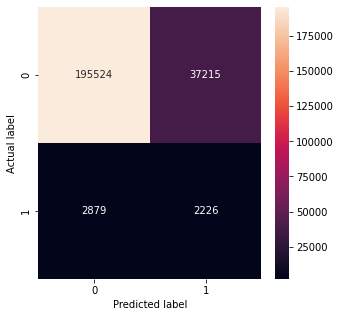

AUC: 0.7413996692852282


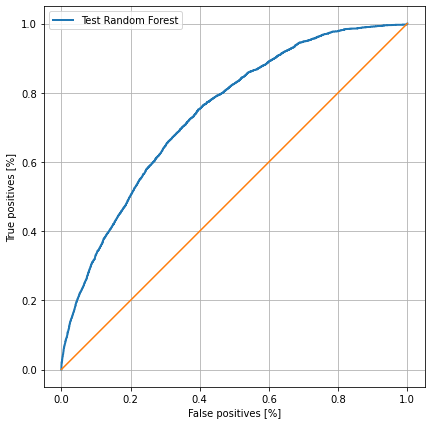

AUC: 0.07474288884188868


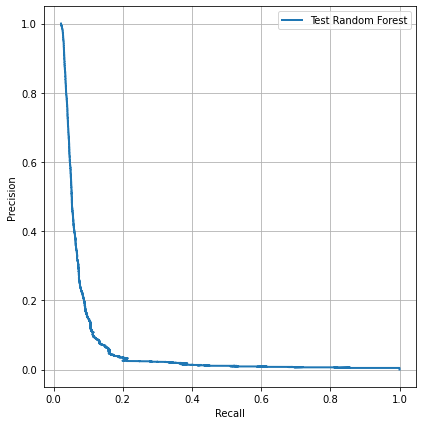

In [7]:
predictons_proba = rand_forest_baseline.predict_proba(X_test)[: , 1]
predictions      = rand_forest_baseline.predict(X_test)
plot_cm(y_test, predictions)
plot_roc("Test Random Forest", y_test, predictons_proba)
plot_prc("Test Random Forest", y_test, predictons_proba)

Perform feature selection

In [10]:
NUM_ESTIMATORS = 100
RANDOM_SEED    = 1211
      
rf_selector = SelectFromModel(
                             RandomForestClassifier(n_estimators = NUM_ESTIMATORS, random_state = RANDOM_SEED),
                             max_features = len(X_feature),
                             )


rf_selector.fit(X_train, y_train)
rf_support = rf_selector.get_support()
rf_features = X_train.loc[:, rf_support].columns.tolist()
print('Selected Features')
print(rf_features)
print(len(rf_features))

Selected Features
['HR', 'Temp', 'MAP', 'Resp', 'PaCO2', 'BUN', 'Chloride', 'Creatinine', 'Glucose', 'Potassium', 'Hgb', 'PTT', 'WBC', 'Platelets', 'Age']
15


In [11]:
print("Selected Features")
print(rf_features)

Selected Features
['HR', 'Temp', 'MAP', 'Resp', 'PaCO2', 'BUN', 'Chloride', 'Creatinine', 'Glucose', 'Potassium', 'Hgb', 'PTT', 'WBC', 'Platelets', 'Age']


In [12]:
# pick only selected features.
X_train_fs = X_train[rf_features] 
y_train_fs = y_train
X_valid_fs = X_valid[rf_features]
y_valid_fs = y_valid
X_test_fs  = X_test[rf_features]
y_test_fs  = y_test

Train Random Forest using selected Features

In [13]:
MAX_DEPTH = 10
NUM_OF_TREES_IN_FOREST = 150
rand_forest_fselect = RandomForestClassifier(
                                            random_state=RANDOM_SEED,
                                            oob_score=True,
                                            max_depth=MAX_DEPTH,
                                            n_estimators = NUM_OF_TREES_IN_FOREST,
                                            class_weight='balanced_subsample' #adds weight to minorty class!!!
                                            )

'''
rand_forest_fselect.fit(X_train_fs, y_train_fs)
'''

'\nrand_forest_fselect.fit(X_train_fs, y_train_fs)\n'

In [14]:
with open("models/rand_forest_feature_sel.pkl", "rb") as f:
    rand_forest_fselect = pickle.load(f)

#with open("models/rand_forest_feature_sel.pkl", "wb") as f:
#    pickle.dump(rand_forest_fselect, f)

Evaluate model performance

In [15]:
display_performance(rand_forest_fselect, X_test_fs, y_test_fs)

Accuarcy  = 0.8278703688131717
Recall    = 0.4472086190009794
Precision = 0.056508502264795424
F1Score   = 0.10033841691205556
F2Score   = 0.18768188619062495


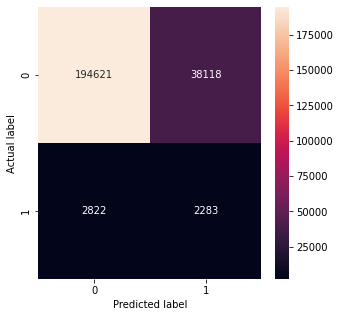

AUC: 0.7448701792412318


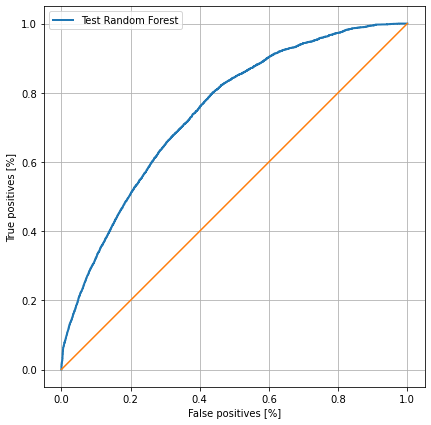

AUC: 0.07297079959307043


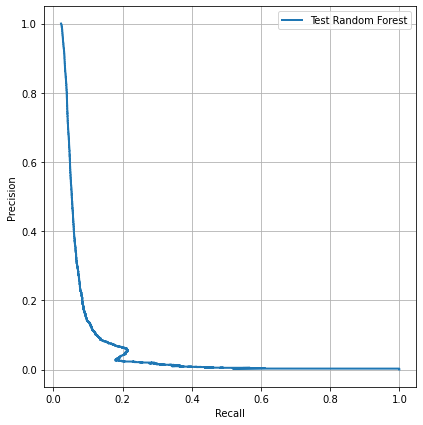

In [16]:
predictons_proba = rand_forest_fselect.predict_proba(X_test_fs)[: , 1]
predictions      = rand_forest_fselect.predict(X_test_fs)
plot_cm(y_test, predictions)
plot_roc("Test Random Forest", y_test_fs, predictons_proba)
plot_prc("Test Random Forest", y_test_fs, predictons_proba)